In [16]:
from IPython.display import HTML								# Allow HTML editing
from IPython.display import display, Math, Latex				# Allow Latex editing
import IPython.core.display as di								# Allow toggle function of code-blocks

# Toggle solution by Max Masnick
# Source: http://protips.maxmasnick.com/hide-code-when-sharing-ipython-notebooks
# This line will hide code by default when the notebook is exported as HTML 
# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
print('This button will toggle the underlying code used in each and every step.')
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


This button will toggle the underlying code used in each and every step.


Toggle code

<h3>Project Name : Cable Failure (CF) </h3>

<u> Scope </u> : Calculation of a Cable Score per OTE customer (Athens/Greece)




<h1> <a id="initialize_use_case_asset"></a>Initialize use case asset</h1>

The objective of this notebook is to use machine learning and data analysis techniques in order to predict customer behavior via network measurements and customer trouble tickets (CTT) is expected to provide findings in early cable failure detection. This notebook demostrates a  predictive modeling problem broken down according to CRISP-dm steps. CRISP-dm is an open standard process model that describes common approaches followed by data scientists. 

<h3> <a id="initialize_use_case_asset"></a>Initialize use case asset</h3>

<a href="#initialize_use_case_asset">0 Initialize use case asset</a><br>
<a href="#crisp_business_understanding"> 1 Business Understanding </a><br>
<a href="#crisp_data_understanding"> 2 Data Understanding </a><br>
<a href="#crisp_preparation"> 3 Data Preparation </a><br>
<a href="#crisp_modeling"> 4 Modeling </a><br>
<a href="#crisp_evaluation"> 5 Evaluation </a><br>
<a href="#crisp_deployment"> 6 Deployment </a><br>

<h2> <a id="Asset_Code_Parts"></a>Asset Code Parts</h2>

<a href="#Feature_Selection_Using_Correlation_Matrix"> 1 Feature Selection Using Correlation Matrix </a><br>
<a href="#Random_Forest _Classifier"> 2 Random Forest Classifier </a><br>
<a href="#Model_Evalulation_Confusion_Matrix"> 3 Model Evalulation - Confusion Matrix</a><br>
<a href="#Printing The Accuracy Metrics"> 4 Printing The Accuracy Metrics</a><br>

<h5>Load all the required libraries needed to run the cable failure usecase.</h5>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import seaborn as sns
sns.set_style("white")

## Initiating Spark
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import Row
import pyspark.sql.functions as F
from pyspark.sql.functions import udf

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.options.display.max_columns = 200

import sys, sklearn, pyspark
print("sklearn:",sklearn.__version__) 
print("pandas:",pd.__version__)
print( "pyspark:",pyspark.__version__)

sklearn: 0.19.2
pandas: 0.23.4
pyspark: 2.3.2


<h1><a id="crisp_business_understanding"></a>Business Understanding</h1>
<a href="#initialize_use_case_asset"> 0 Initialize Use Case Asset</a> |
<b>1 Business Understanding</b> |
<a href="#crisp_data_understanding"> 2 Data Understanding </a>|
<a href="#crisp_preparation"> 3 Data Preparation </a>|
<a href="#crisp_modeling"> 4 Modeling </a>|
<a href="#crisp_evaluation"> 5 Evaluation </a>|
<a href="#crisp_deployment"> 6 Deployment </a>

# [Data_Part](#Heading-Here)

In [3]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

def sparkinit_global():
    spark = SparkSession.builder\
    .master("yarn")\
    .config("spark.submit.deployMode", "client")\
    .config("spark.eventLog.enabled", "true")\
    .config('spark.sql.files.maxPartitionBytes', '134217728')\
    .config("spark.dynamicAllocation.enabled", "true")\
    .config("spark.dynamicAllocation.executorIdleTimeout", "1500s")\
    .config("spark.dynamicAllocation.initialExecutors", "53")\
    .config("spark.executor.cores", "4")\
    .config("spark.executor.memory", "8g")\
    .config("spark.yarn.executor.memoryOverhead", "8g")\
    .config("spark.driver.cores", "4")\
    .config("spark.driver.memory", "8g")\
    .config("spark.yarn.driver.memoryOverhead", "8g")\
    .appName("FirstModel")\
    .getOrCreate()

    sc=spark.sparkContext
    sqlContext = SQLContext(sc)




<h3><a id="Printing The Accuracy Metrics"></a>Printing The Accuracy Metrics</h3>

<a href="#Asset_Code_Parts"> Asset Code Parts </a> |
<a href="#Feature_Selection_Using_Correlation_Matrix"> 1 Feature Selection Using Correlation Matrix </a> |
<a href="#Random_Forest _Classifier"> 2 Random Forest Classifier </a> |
<a href="#Model_Evalulation_Confusion_Matrix"> 3 Model Evalulation - Confusion Matrix</a> |
<b>4 Printing The Accuracy Metrics</b>

In [6]:
def print_confmatrix (conf_matrix):
    target_names = np.array(['no fault', 'fault'], dtype = '<U10')  # U is unicode string length 10
    plot_confusion_matrix(conf_matrix, classes = target_names, normalize= True)
    
    # do the prints
    print('Confusion matrix, without normalization')
    print(conf_matrix)

    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    TN = conf_matrix[0][0]
    FN = conf_matrix[1][0]

    TP=float(TP)
    TN=float(TN)
    FN=float(FN)
    FP=float(FP)

    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    accuracy = (TP + TN)/(TP + TN + FP + FN)

    print("Accuracy = %g " % (accuracy))
    print("Precision = %g " % (precision))
    print("Recall = %g " % (recall))
    print("--------------------------------")


    
# feature importance in random forest
def feature_importance_fr(model, number, X):
    # initiate an empty list to include feature names
    yo = list()
    # define how many features you want
    how_many = number

    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(how_many):
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
        yo.append(X.columns[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(how_many), importances[indices][:how_many],
             align="center")
    plt.xticks(range(how_many), yo, rotation = 90)
    plt.xlim([-1, how_many])
#     plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()



In [7]:
def predict_plots (model,testData,returnpara=False):
    # make predictions
    predictions = model.transform(testData)
    metrics = MulticlassMetrics(predictions.select("prediction", "label1").rdd)
    conf_matrix = metrics.confusionMatrix().toArray()

    print_confmatrix(conf_matrix)
    if (returnpara): return predictions
    return


<h3><a id="Feature_Selection_Using_Correlation_Matrix"></a>Feature Selection Using Correlation Matrix</h3>

<a href="#Asset_Code_Parts"> Asset Code Parts </a> |
<b>1 Feature Selection Using Correlation Matrix</b> |
<a href="#Random_Forest _Classifier"> 2 Random Forest Classifier </a> |
<a href="#Model_Evalulation_Confusion_Matrix"> 3 Model Evalulation - Confusion Matrix</a> |
<a href="#Printing The Accuracy Metrics"> 4 Printing The Accuracy Metrics</a>

In [9]:
#####################################################
# calc correlation matrix
#####################################################
def correlation_matrix(df, columns):
    # import module
    from pyspark.ml.stat import Correlation

    # Vector assembler
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    assembled = assembler.transform(df)
    selected_features = assembled.select("features")

    # compute correlation matrix
    r = Correlation.corr(selected_features, "features").head()

    # transform dense matrix to array in order to finally transform it to Pandas
    array = r[0].toArray()

    # create pandas dataframe
    correlation_matrix = pd.DataFrame(array, columns = columns, index = columns)
    return correlation_matrix

#####################################################
# function to get sorted feature importance list
#####################################################
def sorted_features(fi,allcols):
    ll = []
    for i in range(len(allcols)):
        ll.append([allcols[i], fi[i]])
    l = sorted(ll, key=lambda x: x[1],reverse=True)
    df = pd.DataFrame(l, columns=['feature','importance'])

    return df


#####################################################
#make lists of highly correlated features 
#####################################################
def highly_corr_features(corr_matrix,corrcoeff_from):
    corr_matrix.loc[:,:] =  np.tril(corr_matrix, k=-1)
    already_in = set()
    result = []
    for col in cor_matrix_df:
        perfect_corr = corr_matrix[col][corr_matrix[col] > corrcoeff_from].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    return result

##################################################
# keep this variables from the highly correlated variables
####################################################
# set feature column as index in the pandas dataframe
#df_feature_importance.set_index('feature', drop=True, inplace=True) 
def variable_selection(feature_importance_df, corr_fam , n):
    best_variables_list=[]
    for item in corr_fam:
        indices = list(item)
        variable = tuple(feature_importance_df.loc[indices, :].sort_values(by='importance', axis=0, ascending=False).head(n).index)
        best_variables_list.extend(variable)
        best_variables = set(best_variables_list)
    return best_variables


##################################################
# Final computations in order to choose the 
# variables that gonna be used for the model
##################################################
def get_features (cor_matrix_df, featureImportances, corr_coeff, numericcols,debug=False):

    df_feat_imp = sorted_features(featureImportances, numericcols)
    df_feat_imp.set_index('feature', drop=True, inplace=True) 
    if debug: print(df_feat_imp)

    corr_features = highly_corr_features(cor_matrix_df, corr_coeff)
    if debug: print("-corr_features-",corr_features)

    variables_to_keep = variable_selection(df_feat_imp, corr_features, 1)
    if debug: print(variables_to_keep)

    variables_to_exclude = []
    for item in corr_features :
        for i in item:
            variables_to_exclude.append(i)

    # make the appropriate handling with sets and list in order to 
    # select the variables
    variables_to_exclude = list(set(variables_to_exclude))
    all_columns = set(numericcols)
    variables1 = all_columns.difference(variables_to_exclude)
    final_list_of_variables = list (variables1.union(variables_to_keep)) 

    if debug: print(variables_to_exclude)
    if debug: print(variables1)
    if debug: print("-final-list_of_variable-",final_list_of_variables,len(final_list_of_variables))
    if debug: prin( df_feat_imp.loc[features, :].sort_values(by='importance', axis=0, ascending=False))

    return final_list_of_variables, df_feat_imp


In [10]:
def readlist(fn):
#    print os.path.isfile(fn) 
    f = open(fn)
    l = []
    for line in f:
        words = line.split()
        for w in words:
            l.append(w)
    f.close()
    return  l


def writelist(words, fn):
    fwords = open(fn, 'w')
    for word in words:
        fwords.write (word + "\n")
    fwords.close()
    return


In [11]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [12]:
import os
#os.chdir('C:/Users/skumar26/Downloads/Compressed/CAble failure/UC-OTE-CableFailure-master/uc-ote-cablefailure/UC-CableFailure-NonHarmonized')
#cablefailuredir = os.getcwd()
#print (cablefailuredir)

C:\Users\skumar26\Downloads\Compressed\CAble failure\UC-OTE-CableFailure-master\uc-ote-cablefailure\UC-CableFailure-NonHarmonized


<h1><a id = "crisp_data_understanding"></a>Data understanding</h1>
<a href="#initialize_use_case_asset"> 0 Initialize Use Case</a> 
<a href="#crisp_business_understanding"> 1 Business Understanding </a>|
<b>2 Data Understanding</b>
<a href="#crisp_preparation"> 3 Data Preparation </a>|
<a href="#crisp_modeling"> 4 Modeling </a>|
<a href="#crisp_evaluation"> 5 Evaluation </a>|
<a href="#crisp_deployment"> 6 Deployment </a>

<h4>Dataset columns:</h4>

<h5> Numeric Data Type Columns </h5> :   
measurement_date,kv2,kv_lat,kv_lon,prom_id,high_temp,low_temp,mean_temp
rain,retrains,i1_mean,i4,i2,i1_retrains,i1_disconnections,i1_up,i1_down
i1,calc_sign_att,up_avg_rate,dn_avg_rate,b2,b1,neighbors,dailyretrains
dailydisconnections,ar_min_rate,ar_max_rate,ac_min_rate,ac_max_rate
up_sign_attn,dn_sign_attn,up_crt_rate,dn_crt_rate,ar_tgt_snr,up_snr
ac_tgt_snr,dn_snr,estim_length,min_actualdatarateupstream,min_actualdataratedownstream
min_acctsessiontime,min_acctoutputoctets,min_acctinputoctets,max_actualdatarateupstream
max_actualdataratedownstream,max_acctsessiontime,max_acctoutputoctets,max_acctinputoctets
disconnections,avg_actualdatarateupstream,avg_actualdataratedownstream,avg_acctsessiontime
avg_acctoutputoctets,avg_acctinputoctets,prod_identifier

<h5> Target Variable (Boolean): </h5> label

In [13]:
local = True
dir_obj =  "/obj/"
fpath = "/data/"

# dir_obj = cablefailuredir + "/obj/"
# fpath = cablefailuredir + "/data/"

#fname0="non_cable_fault_only0/non_cable_fault_only0.csv"
#fname1="final_dataset_new/final_dataset_new.csv"

fname0 = 'resources_non_cable_final_cf_downsample.csv_b'
fname1 = 'resources_cable_final_cf.csv_b'

#PerformanceIndicator
# features to use in the algorithms
# previously cols_measure now cols_PerformanceIndicator
cols_PerformanceIndicator = ['retrains', 'i1_mean', 'i4', 'i2', 'i1_retrains',
           'i1_disconnections', 'i1_up', 'i1_down', 'i1', 'calc_sign_att',
           'up_avg_rate', 'dn_avg_rate', 'b2', 'b1', 'neighbors', 'dailyretrains',
           'dailydisconnections', 'ar_min_rate', 'ar_max_rate', 'ac_min_rate',
           'ac_max_rate', 'up_sign_attn', 'dn_sign_attn', 'up_crt_rate',
           'dn_crt_rate', 'ar_tgt_snr', 'up_snr', 'ac_tgt_snr', 'dn_snr',
           'estim_length', 'min_actualdatarateupstream',
           'min_actualdataratedownstream', 'min_acctsessiontime',
           'min_acctoutputoctets', 'min_acctinputoctets',
           'max_actualdatarateupstream', 'max_actualdataratedownstream',
           'max_acctsessiontime', 'max_acctoutputoctets', 'max_acctinputoctets',
           'disconnections', 'avg_actualdatarateupstream',
           'avg_actualdataratedownstream', 'avg_acctsessiontime',
           'avg_acctoutputoctets', 'avg_acctinputoctets']
cols_weather = ['high_temp','low_temp', 'mean_temp', 'rain']
#numericcols = cols_PerformanceIndicator + cols_weather
numericcols = cols_PerformanceIndicator 
nonnumericcols = ['measurement_date','prod_identifier','kv2','kv_lat','kv_lon','prom_id'] + cols_weather

allcolumns = nonnumericcols + numericcols + ['label']

print(len(cols_PerformanceIndicator))

46


In [14]:
if (local):
    sc = SparkContext.getOrCreate()
    sqlContext = SQLContext(sc)
    df1 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true') \
     .load(fpath+fname1)
    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true') \
     .load(fpath+fname0)
else:
    sc, sqlContext = sparkinit_global()
    df1 = sqlContext.sql("""SELECT * FROM data_analyst.cable_final_cf""")
    df = sqlContext.sql("""SELECT * FROM data_analyst.non_cable_final_cf_downsample""")

print(df1.count(),len(df1.columns))
print(df.count())


44913 57
61681


<h1><a id="crisp_preparation"></a>Data preparation</h1>
<a href="#initialize_use_case_asset"> 0 Initialize Use Case</a> |
<a href="#crisp_business_understanding"> 1 Business Understanding </a>|
<a href="#crisp_data_understanding"> 2 Data Understanding </a>|
<b>3 Data Preparation</b>|
<a href="#crisp_modeling"> 4 Modeling </a>|
<a href="#crisp_evaluation"> 5 Evaluation </a>|
<a href="#crisp_deployment"> 6 Deployment </a>

In [15]:
df1 = df1.select(allcolumns)
df = df.select(allcolumns)
df = df1.union(df)

print(df.count(),len(df.columns))

df = df.coalesce(4)

106594 57


In [29]:
#df1.show(2)

<a id='another_cell'></a>

In [16]:
import unidecode
unidecode.unidecode(u'αβγδ')

'abgd'

## Heading Here

In [17]:
a = u'1654-ΣΠΑ-111'
from transliterate.utils import translit
print( translit(a, 'el', reversed=True))
import unidecode

@udf('string')
def udf_translit(v):
#    v2 = translit(v,'el',reversed=True)
    # v2 = unidecode.unidecode(v)
    v2 = v
    return v2

df = df.withColumn('prom_id', udf_translit(df.prom_id))

print( udf_translit(u'1654-ΣΠΑ-111'))2

1654-SPA-111
Column<b'udf_translit(1654-\xce\xa3\xce\xa0\xce\x91-111)'>


In [59]:
??translit


In [18]:
from pyspark.sql.types import FloatType, DoubleType

for x in df.schema:
    if (x.name in (numericcols)):
        if (x.dataType == FloatType()):
            continue
        elif (x.dataType == DoubleType()):
            continue
        else:
            print(x.name, x.dataType)
            df = df.withColumn(x.name, df[x.name].cast(DoubleType()).alias(x.name))


In [19]:
from pyspark.sql.functions import col,sum

if (local):
    dfcol = []
    for x in nonnumericcols: dfcol.append(df[x])
    for c in numericcols: dfcol.append(df[c].cast("float"))
    dfcol.append(df['label'].cast("int"))

    dfml = df.select(*dfcol)
else:
    dfml = df.select([c for c in df.columns if c in allcolumns])

# make a new column label1 of type double and drop ori label
dfml = dfml.withColumn('label1', dfml['label'].astype('double'))
dfml = dfml.drop('label')

# remove all rows labelled not [0,1]
dfml = dfml.where((col("label1") == '0') | (col("label1") == '1'))


In [27]:
#dfml.show(2)

In [20]:
def testprint(dfml, collbl, describepandas=False):
    print(dfml.groupby(collbl).count().show())
        
    if (describepandas):
        print( dfml.describe().toPandas().transpose())
    return

testprint(dfml, 'label1', describepandas=False)

# take a sample in order to make the target variable equally distributed stratified sampling and drop duplicates
dfml = dfml.sampleBy("label1", fractions={0.0: 0.4, 1.0: 1}, seed=0).dropDuplicates()

replace_missing_values_and_NANs = list (set (numericcols) - set(['high_temp','low_temp', 'mean_temp', 'rain']))
for x in replace_missing_values_and_NANs:
    dfml = dfml.na.fill(-999,[x])

testprint(dfml, 'label1', describepandas=False)


+------+-----+
|label1|count|
+------+-----+
|   0.0|53070|
|   1.0|22702|
+------+-----+

None
+------+-----+
|label1|count|
+------+-----+
|   0.0|21411|
|   1.0|22594|
+------+-----+

None


In [21]:
dfml.toPandas().to_csv(dir_obj + 'df_ml2.csv',  sep=',', encoding='utf-8', index=False)

df1 = dfml.na.drop(how='any',subset=nonnumericcols)
testprint(df1, 'label1', describepandas=False)


+------+-----+
|label1|count|
+------+-----+
|   0.0|20454|
|   1.0|20887|
+------+-----+

None


<h1><a id="crisp_modeling"></a>Modeling</h1>
<a href="#initialize_use_case_asset"> 0 Initialize Use Case</a> |
<a href="#crisp_business_understanding"> 1 Business Understanding </a>|
<a href="#crisp_data_understanding"> 2 Business Understanding </a>|
<a href="#crisp_preparation"> 3 Data Preparation </a>|
<b>4 Modeling</b>
<a href="#crisp_evaluation"> 5 Evaluation </a>|
<a href="#crisp_deployment"> 6 Deployment </a>

<h3><a id="Random_Forest _Classifier"></a>Random Forest Classifier</h3>

<a href="#Asset_Code_Parts"> Asset Code Parts </a> |
<a href="#Feature_Selection_Using_Correlation_Matrix"> 1 Feature Selection Using Correlation Matrix </a>
<b>2 Random Forest Classifier</b> |
<a href="#Model_Evalulation_Confusion_Matrix"> 3 Model Evalulation - Confusion Matrix</a> |
<a href="#Printing The Accuracy Metrics"> 4 Printing The Accuracy Metrics</a>

In [54]:
# remove missing values
import pandas as pd
import numpy as np

df1 = dfml.na.drop().drop('measurement_date', 'sr_num', 'prod_identifier', 'kv2', 'kv_lat', 'kv_lon')




from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql import *

assembler = VectorAssembler(inputCols=numericcols, outputCol="features")
assembled = assembler.transform(df1)

# split the data
(trainingData, testData) = assembled.randomSplit([0.75, 0.25], seed = 0)
print( trainingData.count(), testData.count())

trainingData=trainingData.coalesce(4)
testData=testData.coalesce(4)


30973 10368


In [56]:
print(type(df1))
print(type(trainingData))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [58]:
pdf1 = df1.toPandas()
pdf2 = trainingData.toPandas()
# print(type(df1))
# print(type(pandas_df))
pdf1.to_csv(r'C:\Users\skumar26\Desktop\Day Work\Assets\IDF\chk\df1.csv', index = None, header=True) 
pdf2.to_csv(r'C:\Users\skumar26\Desktop\Day Work\Assets\IDF\chk\df2.csv', index = None, header=True) 

In [52]:
pandas_df = df1.toPandas()
print(type(df1))
print(type(pandas_df))
pandas_df.to_csv(r'C:\Users\skumar26\Desktop\Day Work\Assets\IDF\df1.csv', index = None, header=True) 


<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [23]:
from pyspark.ml.classification import RandomForestClassifier

# 2 parameters numTrees,maxDepth adopted
rf = RandomForestClassifier(numTrees=10, maxDepth=15, labelCol="label1", featuresCol="features")
model = rf.fit(trainingData)
model_full = model.copy()


In [55]:
??RandomForestClassifier

Normalized confusion matrix
[[0.79948688 0.20051312]
 [0.05640445 0.94359555]]
Confusion matrix, without normalization
[[4051. 1016.]
 [ 299. 5002.]]
Accuracy = 0.873167 
Precision = 0.831173 
Recall = 0.943596 
--------------------------------


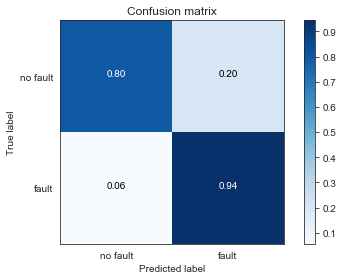

In [24]:
#predict_plots (model,trainingData)
predict_plots (model,testData)

In [25]:
cor_matrix_df = correlation_matrix(df1, numericcols)

features, df_feat_imp = get_features (cor_matrix_df, model_full.featureImportances, 0.8, numericcols, debug=False)
print( features,len(features))

df_feat_imp.loc[features, :].sort_values(by='importance', axis=0, ascending=False)
writelist(features,dir_obj + "features080.csv")
features_080 = features[:]

['neighbors', 'disconnections', 'min_actualdatarateupstream', 'avg_acctinputoctets', 'min_acctoutputoctets', 'ac_min_rate', 'retrains', 'ar_tgt_snr', 'estim_length', 'dn_sign_attn', 'avg_acctsessiontime', 'up_crt_rate', 'dailydisconnections'] 13


In [37]:
print(cor_matrix_df.head(5))

             retrains   i1_mean        i4        i2  i1_retrains  \
retrains     0.000000  0.000000  0.000000  0.000000          0.0   
i1_mean     -0.053377  0.000000  0.000000  0.000000          0.0   
i4          -0.050770  0.999701  0.000000  0.000000          0.0   
i2          -0.065535  0.839633  0.838401  0.000000          0.0   
i1_retrains -0.062925  0.996362  0.995439  0.841873          0.0   

             i1_disconnections  i1_up  i1_down   i1  calc_sign_att  \
retrains                   0.0    0.0      0.0  0.0            0.0   
i1_mean                    0.0    0.0      0.0  0.0            0.0   
i4                         0.0    0.0      0.0  0.0            0.0   
i2                         0.0    0.0      0.0  0.0            0.0   
i1_retrains                0.0    0.0      0.0  0.0            0.0   

             up_avg_rate  dn_avg_rate   b2   b1  neighbors  dailyretrains  \
retrains             0.0          0.0  0.0  0.0        0.0            0.0   
i1_mean         

<h1> <a id="crisp_evaluation"></a>Evaluation</h1> 
<a href="#initialize_use_case_asset"> 0 Initialize Use Case</a> |
<a href="#crisp_business_understanding"> 1 Business Understanding </a>|
<a href="#crisp_data_understanding"> 2 Business Understanding </a>|
<a href="#crisp_preparation"> 3 Data Preparation </a>|
<a href="#crisp_modeling"> 4 Modeling </a>|
<a href="#crisp_evaluation"> <b>5 Evaluation</b></a>|
<a href="#crisp_deployment"> 6 Deployment</a>

In [26]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(df1)

# split the data
(trainingData, testData) = assembled.randomSplit([0.75, 0.25], seed = 0)
print(trainingData.count(), testData.count())

trainingData=trainingData.coalesce(4)
testData=testData.coalesce(4)


30973 10368


<h3><a id="Model_Evalulation_Confusion_Matrix"></a>Model Evalulation - Confusion Matrix</h3>

<a href="#Asset_Code_Parts"> Asset Code Parts </a> |
<a href="#Feature_Selection_Using_Correlation_Matrix"> 1 Feature Selection Using Correlation Matrix </a>
<a href="#Random_Forest _Classifier"> 2 Random Forest Classifier </a>
<b>3 Model Evalulation - Confusion Matrix</b> |
<a href="#Printing The Accuracy Metrics"> 4 Printing The Accuracy Metrics</a>

Normalized confusion matrix
[[0.78172489 0.21827511]
 [0.07489153 0.92510847]]
Confusion matrix, without normalization
[[3961. 1106.]
 [ 397. 4904.]]
Accuracy = 0.855035 
Precision = 0.815973 
Recall = 0.925108 
--------------------------------


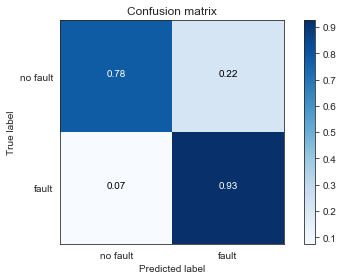

In [27]:
rf = RandomForestClassifier(numTrees=10, maxDepth=15, labelCol="label1", featuresCol="features")
model = rf.fit(trainingData)

predict_plots (model,testData)


In [28]:
cor_matrix_df = correlation_matrix(df1, numericcols)
features, df_feat_imp = get_features (cor_matrix_df, model_full.featureImportances, 0.95, numericcols, debug=False)
print( features,len(features))
writelist(features,dir_obj + "features095.csv")

['neighbors', 'ac_max_rate', 'max_acctoutputoctets', 'disconnections', 'dn_crt_rate', 'ar_min_rate', 'ac_min_rate', 'retrains', 'avg_actualdataratedownstream', 'ar_max_rate', 'ar_tgt_snr', 'avg_acctsessiontime', 'dailydisconnections', 'i2', 'min_actualdatarateupstream', 'max_actualdatarateupstream', 'avg_acctinputoctets', 'min_acctoutputoctets', 'estim_length', 'dn_avg_rate', 'dn_sign_attn', 'dn_snr', 'min_actualdataratedownstream', 'up_crt_rate', 'up_avg_rate'] 25


In [29]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(df1)

# split the data
(trainingData, testData) = assembled.randomSplit([0.75, 0.25], seed = 0)
print( trainingData.count(), testData.count())
trainingData=trainingData.coalesce(4)
testData=testData.coalesce(4)

30973 10368


Normalized confusion matrix
[[0.78586935 0.21413065]
 [0.05904546 0.94095454]]
Confusion matrix, without normalization
[[3982. 1085.]
 [ 313. 4988.]]
Accuracy = 0.865162 
Precision = 0.82134 
Recall = 0.940955 
--------------------------------


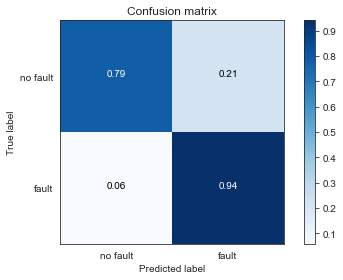

In [30]:
rf = RandomForestClassifier(numTrees=10, maxDepth=15, labelCol="label1", featuresCol="features")
model = rf.fit(trainingData)

prediction = predict_plots (model,testData,returnpara=True)

C:\Users\skumar26\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\skumar26\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\skumar26\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\skumar26\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predicti

Normalized confusion matrix
[[0.79001381 0.20998619]
 [0.06074326 0.93925674]]
Confusion matrix, without normalization
[[4003 1064]
 [ 322 4979]]
Accuracy = 0.866319 
Precision = 0.823929 
Recall = 0.939257 
--------------------------------


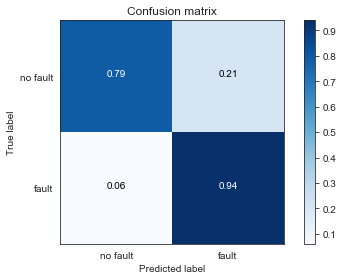

In [31]:
pd_train = trainingData.toPandas()
pd_test = testData.toPandas()
#save_obj(pd_train, dir_obj + 'pandas-train.pkl')
#save_obj(pd_Test, dir_obj + 'pandas-test.pkl')


features = readlist(dir_obj + "features080.csv")
#pd_train=load_obj(dir_obj + 'pandas-train.pkl')
#pd_test =load_obj(dir_obj + 'pandas-test.pkl')


# input: print trainingData.count(), testData.count()
def getXy (df_pd):
    X = df_pd[features]
    y = df_pd[['label1']]
    return X,y

X_train, y_train = getXy(pd_train)
X_test, y_test = getXy(pd_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf_sk = RandomForestClassifier(max_features = 10, random_state = 0, oob_score=True, 
                              max_depth = 15, n_estimators = 10, n_jobs = -1)
clf_sk.fit(X_train, y_train)

pred_lbl = clf_sk.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_lbl)
print_confmatrix(conf_matrix)



In [32]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

firstelement=udf(lambda v:float(v[0]),FloatType())
secondelement=udf(lambda v:float(v[1]),FloatType())

predictions2 = prediction.withColumn("prob0",firstelement('probability')).withColumn("probability_of_cable_failure", secondelement('probability'))


from pyspark.sql.functions import count, avg
from pyspark.sql.functions import sum
import pyspark.sql.functions as F

# group by kv in order to make a list of KV's
kvs2 = predictions2.groupby('prom_id').agg(avg("probability_of_cable_failure"), count("*"), sum('prediction')).withColumnRenamed('avg(probability_of_cable_failure)',"Average_Probability_OF_Cable_Failure").withColumnRenamed('count(1)',"Total_Subscribers").withColumnRenamed('sum(prediction)',"Total_Positive_Predicted_Subscribers").sort("Total_Positive_Predicted_Subscribers", ascending=False)
kvs2df = kvs2.withColumn('percentage', F.col("Total_Positive_Predicted_Subscribers") / F.col('Total_subscribers') )

kvs2df = kvs2df.toPandas()
kvs2df.head(2)


,prom_id,Average_Probability_OF_Cable_Failure,Total_Subscribers,Total_Positive_Predicted_Subscribers,percentage
0,7851-KhAL-568,0.687422,92,73.0,0.793478
1,5058-MAN-331,0.705645,69,61.0,0.884058


In [33]:
kvs = kvs2df[(kvs2df['percentage'] >= 0.2) & (kvs2df['Total_Positive_Predicted_Subscribers'] > 2 )]
print(len(kvs2df),len(kvs))
# kvs.to_csv(dir_obj + 'pd_kvs.csv', sep='|', encoding='utf-8')

kvs.sort_values(by="percentage", ascending=False).head(3)


3034 588


,prom_id,Average_Probability_OF_Cable_Failure,Total_Subscribers,Total_Positive_Predicted_Subscribers,percentage
587,9262-NSM-602,0.799270,3,3.0,1.0
145,3704-KIAT-337,0.729118,11,11.0,1.0
220,9804-RIO-341,0.812512,7,7.0,1.0


<h1><a id="crisp_deployment"></a>Deployment</h1>
<a href="#initialize_use_case_asset"> 0 Initialize Use Case</a> |
<a href="#crisp_business_understanding"> 1 Business Understanding </a>|
<a href="#crisp_data_understanding"> 2 Business Understanding </a>|
<a href="#crisp_preparation"> 3 Data Preparation </a>|
<a href="#crisp_modeling"> 4 Modeling </a>|
<a href="#crisp_evaluation"> 5 Evaluation </a>|
<b>6 Deployment</b>